In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import tqdm

In [2]:
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

In [3]:
stages = range(1,22) # 22
years = range(1990,2022)
stages_dict = {}

for year in years:
    for stage in stages:
        stage_name = f"tdf_{stage}_{year}"
        url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/stage-{stage}"
        stages_dict[stage_name] = url

print(len(stages_dict))

672


In [4]:
def get_data(races_dict: dict) -> dict:
    data_list = []
    error_log = dict()
    for race in tqdm.tqdm(races_dict, desc="Progress bar on fetching stages data", unit="stage"):
        trycnt = 3  # max try cnt
        while trycnt > 0:
            try:
                #print(f"{race}")
                time.sleep(3)
                url = races_dict[race]
                page = requests.get(url, headers=header)
                soup = BeautifulSoup(page.content, 'html.parser')
                data = soup.find('ul',{'class':'infolist'}).get_text().strip().split('\n')
                data_dict = {point.split(': ')[0].strip():point.split(': ')[1].strip() for point in data}
                data_dict['Race'] = race
                data_dict['Stage'] = race.split('_')[1]
                trycnt = 0 # success
                yield data_dict

            except AttributeError as e:
                error_log[race] = e
                trycnt = 0 # No retry

            except requests.exceptions.ChunkedEncodingError as e:
                if trycnt <= 0: print("Failed to retrieve: " + url + "\n" + str(e))  # done retrying
                else: trycnt -= 1  # retry
                time.sleep(0.5)  # wait 1/2 second then retry

In [5]:
data_list = [pd.DataFrame(data, index=[0]) for data in get_data(stages_dict)]

Progress bar on fetching stages data: 100%|██████████| 672/672 [1:12:36<00:00,  6.48s/stage]  


In [11]:
df = pd.concat(data_list).reset_index(drop=True)

df.columns = ['date','start_time','avg_speed','race_category','distance','points_scale','uci_scale',
              'parcour_type','profile_score','elevation','departure','arrival','race_ranking',
              'startlist_quality_score','won_how','race','stage']

distance = df.distance.str.split(' ',expand=True)
avg_speed = df.avg_speed.str.split(' ',expand=True)

df.distance = distance[0]
df['distance_units'] = distance[1]

df.avg_speed = avg_speed[0]
df['avg_speed_units'] = avg_speed[1]

df.date = pd.to_datetime(df.date).dt.date
df['year'] = pd.to_datetime(df.date).dt.year

df.distance = pd.to_numeric(df.distance)
df.elevation = pd.to_numeric(df.elevation)

#df['year'] = df.date.dt.year

In [12]:
df

,date,start_time,avg_speed,race_category,distance,points_scale,uci_scale,parcour_type,profile_score,elevation,departure,arrival,race_ranking,startlist_quality_score,won_how,race,stage,distance_units,avg_speed_units,year
0,1990-07-01,-,41.76,ME - Men Elite,138.5,GT.A.Stage,,,,NaN,Futuroscope,Futuroscope,0,1860,? - let us know!,tdf_1_1990,1,km,km/h,1990
1,1990-07-01,-,50,ME - Men Elite,44.5,GT.A.TTT,,,,NaN,Futuroscope,Futuroscope,0,1860,Time Trial,tdf_2_1990,2,km,km/h,1990
2,1990-07-02,-,40.38,ME - Men Elite,233.0,GT.A.Stage,,,,NaN,Poitiers,Nantes,0,1860,? - let us know!,tdf_3_1990,3,km,km/h,1990
3,1990-07-03,-,37.64,ME - Men Elite,203.0,GT.A.Stage,,,,NaN,Nantes,Mont-Saint-Michel,0,1860,? - let us know!,tdf_4_1990,4,km,km/h,1990
4,1990-07-04,-,39,ME - Men Elite,301.0,GT.A.Stage,,,,NaN,Avranches,Rouen,0,1860,? - let us know!,tdf_5_1990,5,km,km/h,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,2021-07-14,12:10,35.267,ME - Men Elite,178.4,GT.A.Stage,UCI.WR.GT.A.Stage,,450,4375.0,Muret,Saint-Lary-Soulan (Col du Portet),1,1646,Sprint of small group,tdf_17_2021,17,km,km/h,2021
656,2021-07-15,13:50,36.407,ME - Men Elite,129.7,GT.A.Stage,UCI.WR.GT.A.Stage,,367,3561.0,Pau,Luz Ardiden,1,1646,0.6 km solo,tdf_18_2021,18,km,km/h,2021
657,2021-07-16,12:30,47.901,ME - Men Elite,207.0,GT.A.Stage,UCI.WR.GT.A.Stage,,16,1181.0,Mourenx,Libourne,1,1646,26 km solo,tdf_19_2021,19,km,km/h,2021
658,2021-07-17,13:05,51.5,ME - Men Elite,30.8,GT.A.Stage,UCI.WR.GT.A.Stage,,8,246.0,Libourne,Saint-Émilion,1,1646,Time Trial,tdf_20_2021,20,km,km/h,2021


In [14]:
df_test = df[['year','distance','elevation']]

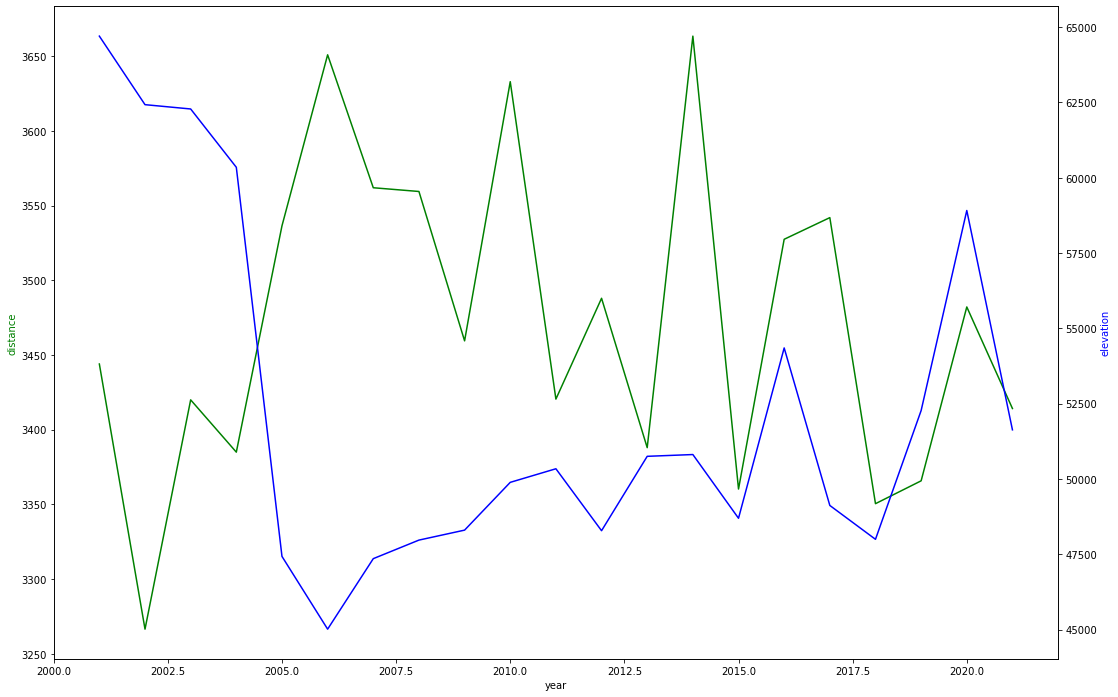

In [15]:
for_plot = df_test.groupby(by='year').sum()
plot_range = for_plot.index > 2000
for_plot = for_plot.loc[plot_range]

fig, ax1 = plt.subplots(figsize=(18, 12))

ax2 = ax1.twinx()
ax1.plot(for_plot.index, for_plot.distance, 'g-')
ax2.plot(for_plot.index, for_plot.elevation, 'b-')

ax1.set_xlabel('year')
ax1.set_ylabel('distance', color='g')
ax2.set_ylabel('elevation', color='b')

plt.show()

In [17]:
df[['year','race','distance','elevation','avg_speed']].sort_values(by=['elevation'],ascending=False).head(10)

,year,race,distance,elevation,avg_speed
236,2001,tdf_10_2001,209.0,8559.0,32.675
303,2004,tdf_17_2004,204.5,8048.0,32.996
261,2002,tdf_15_2002,226.5,7679.0,38.253
299,2004,tdf_13_2004,205.5,7516.0,33.815
274,2003,tdf_8_2003,219.0,7299.0,36.755
280,2003,tdf_14_2003,191.5,7107.0,34.622
239,2001,tdf_13_2001,194.0,7095.0,33.801
258,2002,tdf_12_2002,199.5,6808.0,33.21
363,2007,tdf_16_2007,218.5,6031.0,34.2
275,2003,tdf_9_2003,184.5,5931.0,36.656


In [18]:
# Save data to csv
df.to_csv('data/tdf_stages.csv',index=False,sep='~')